## Role Labeling
Section 4.2.3 in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/hyunsung/Workspace/footballcpd'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from shutil import copyfile
from src.myconstants import *

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
# plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.size'] = 15

In [3]:
%load_ext autoreload
%autoreload 2

from src.myconstants import *
from src.formmanager import FormManager

In [4]:
form_periods = pd.read_pickle('data/form_periods.pkl')
role_records = pd.read_csv('data/role_records.csv', header=0, encoding='utf-8-sig')
activity_records = pd.read_csv('data/activity_records.csv', header=0, encoding='utf-8-sig')

form_periods = pd.merge(
    activity_records[[LABEL_ACTIVITY_ID, LABEL_TEAM_ID, LABEL_DATE, LABEL_TEAM_NAME]], form_periods
)
# role_records[LABEL_START_DT] = role_records[LABEL_START_DT].apply(
#     lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# role_records[LABEL_END_DT] = role_records[LABEL_END_DT].apply(
#     lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

form_periods.head()

,activity_id,team_id,date,team_name,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,1879,8,20200101,anonymous,1,1,hidden,hidden,2820.0,"[[1710.0, -60.0], [133.0, -750.0], [1042.0, 18...","[[0.0, 0.715, 0.916, 0.974, 0.252, 0.023, 0.11...",16,433
1,1879,8,20200101,anonymous,2,2,hidden,hidden,3060.0,"[[1701.0, 24.0], [643.0, -620.0], [674.0, 1848...","[[0.0, 0.864, 0.888, 0.847, 0.266, 0.062, 0.1,...",16,433
2,1882,127,20200101,anonymous,1,1,hidden,hidden,2760.0,"[[-620.0, 1799.0], [-1366.0, -682.0], [-1525.0...","[[0.0, 0.124, 0.976, 0.907, 0.235, 0.99, 0.041...",-1,others
3,1882,127,20200101,anonymous,2,2,hidden,hidden,2520.0,"[[-896.0, 1434.0], [-1231.0, -705.0], [-1400.0...","[[0.0, 0.253, 0.995, 0.764, 0.177, 0.942, 0.12...",5,4132
4,1882,127,20200101,anonymous,2,3,hidden,hidden,420.0,"[[-810.0, 1465.0], [-1275.0, -668.0], [-1832.0...","[[0.0, 0.171, 0.986, 0.691, 0.231, 0.865, 0.12...",5,4132


Roles aligned for formation '343'
Roles aligned for formation '352'
Roles aligned for formation '4132'
Roles aligned for formation '4231'
Roles aligned for formation '433'
Roles aligned for formation '442'
Roles aligned for formation 'others'


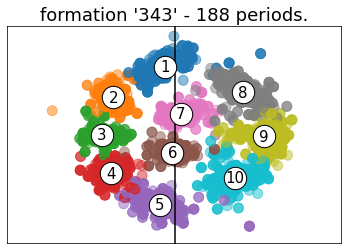

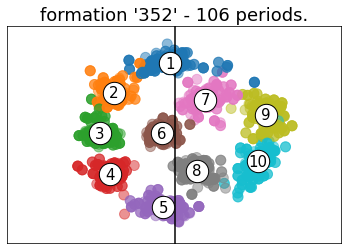

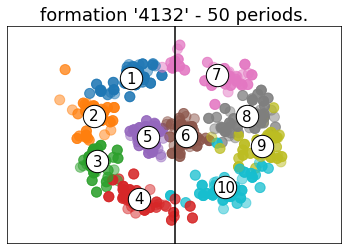

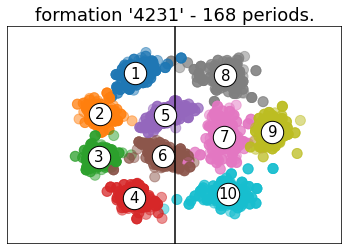

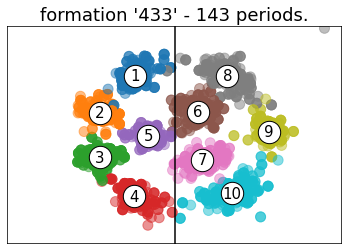

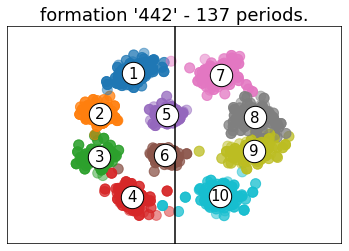

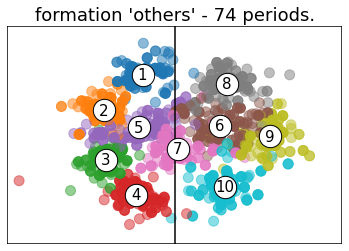

In [5]:
fm = FormManager(form_periods, role_records)
fm.align()
fm.visualize()

In [6]:
role_labels = pd.DataFrame([
    ['343', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'RCM', 'LCM', 'LM', 'CF', 'RM'],
    ['352', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'CDM', 'LCM', 'RCM', 'LCF', 'RCF'],
    ['442', 'LB', 'LCB', 'RCB', 'RB', 'LCM', 'RCM', 'LM', 'LCF', 'RCF', 'RM'],
    ['4132', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'CAM', 'LM', 'LCF', 'RCF', 'RM'],
    ['4231', 'LB', 'LCB', 'RCB', 'RB', 'LDM', 'RDM', 'CAM', 'LM', 'CF', 'RM'],
    ['433', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'LCM', 'RCM', 'LM', 'CF', 'RM'],
    ['others'] + [f'R{i}' for i in list(range(1, 11))]
], columns=[LABEL_FORMATION] + list(range(1, 11))).set_index(LABEL_FORMATION)
role_labels

,1,2,3,4,5,6,7,8,9,10
formation,,,,,,,,,,
343,LWB,LCB,CB,RCB,RWB,RCM,LCM,LM,CF,RM
352,LWB,LCB,CB,RCB,RWB,CDM,LCM,RCM,LCF,RCF
442,LB,LCB,RCB,RB,LCM,RCM,LM,LCF,RCF,RM
4132,LB,LCB,RCB,RB,CDM,CAM,LM,LCF,RCF,RM
4231,LB,LCB,RCB,RB,LDM,RDM,CAM,LM,CF,RM
433,LB,LCB,RCB,RB,CDM,LCM,RCM,LM,CF,RM
others,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10


In [7]:
def give_role_labels(role_records, role_labels):
    formation = role_records[LABEL_FORMATION].iloc[0]
    role_dict = role_labels.loc[formation].to_dict()
    role_records.loc[role_records.index, LABEL_ALIGNED_ROLE] = (
        role_records.loc[role_records.index, LABEL_ALIGNED_ROLE].replace(role_dict)
    )
    return role_records

In [8]:
role_records = fm.role_records.groupby(LABEL_FORMATION).apply(give_role_labels, role_labels)
role_records

,activity_id,session,player_period,form_period,role_period,start_dt,end_dt,duration,player_id,squad_num,player_name,base_role,x,y,formation,aligned_role
0,1879,1,1,1,1,hidden,hidden,2100,1252,9,anonymous,1,1710.0,-60.0,433,CF
1,1879,1,1,1,1,hidden,hidden,2100,1759,10,anonymous,2,133.0,-750.0,433,RCM
2,1879,1,1,1,1,hidden,hidden,2039,1760,14,anonymous,3,1042.0,1812.0,433,LM
3,1879,1,1,1,1,hidden,hidden,2100,1761,15,anonymous,4,814.0,-1458.0,433,RM
4,1879,1,1,1,1,hidden,hidden,2100,1237,19,anonymous,5,-598.0,-96.0,433,CDM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21182,22875,2,4,3,6,hidden,hidden,400,5781,19,anonymous,5,367.0,-385.0,others,R7
21183,22875,2,4,3,6,hidden,hidden,400,5204,20,anonymous,7,-1087.0,-359.0,others,R3
21184,22875,2,4,3,6,hidden,hidden,400,5450,23,anonymous,3,1264.0,-275.0,others,R9
21185,22875,2,4,3,6,hidden,hidden,400,4643,33,anonymous,9,-1185.0,420.0,others,R2
